<a href="https://colab.research.google.com/github/apester/HiddenMarkovModel_TensorFlow/blob/master/HiddenMarkovModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Markov Model in TensorFlow
## Package Includes (so far):
* **Viterbi Algorithm**
    * Maximum a Posteri
<br>
<br>
* **Forward-Backward Algorithm**
    * Posterior Marginals
<br>
<br>
* **Baum Welch Algorithm**
    * Expectation Maximization Inference

## HMM Fundamentals

**HMM recap:**
* Undirected graphical model.
* Connections between nodes indicate dependence.
* We observe $Y_1$ through $Y_n$, which we model as being observed from hidden states $S_1$ through $S_n$.
* Any particular state variable $S_k$ depends only on $S_{k−1}$ (what came before it), $S_{k+1}$ (what comes after it), and $Y_k$ (the observation associated with it).

** HMM are specified by three sets of parameters**

* ** Transition distribution:**
    * describes the distribution for the next state given the current state.
    * $P(next State| current State)$
<br>
<br>
* ** Emission distribution:**
    * describes the distribution for the output given the current state.
    * $P(Observation|current State)$
<br>
<br>
* ** Initial state distribution:**
    * describes the starting distribution over states.
    * $P(initial State)$

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/hmm.png?raw=1)

### State Transitions

<img src="https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/trans2.png?raw=1" width="500" height="500" />

## Viterbi Algorithm
* Efficient way of finding the most likely state sequence.
* Method is general statistical framework of compound decision theory. 
* Maximizes a posteriori probability recursively.
* Assumed to have a finite-state discrete-time Markov process.

**Maximum a posteri (MAP) probability, given by:** <br>
$$P(States|Observations) = \dfrac{P(Observations)| States)P(States)}{P(Observations)}$$

Given a hidden Markov model (HMM) with:
* State space S
* Initial probabilities $\pi_i$ of being in state $i$
* Transition probabilities $a_{i,j}$ of transitioning from state i to state j.
* We observe outputs $y_1$,$\dots$, $y_T$.
* The most likely state sequence $x_1$,$\dots$,$x_T$ that produces the observations is given by the recurrence relations:

$$ V_{1,k} = P(y_1 | k) \cdot \pi_k$$

$$ V_{t,k} = max_x(P(y_t|k)\cdot a_{x,k} \cdot V_{t-1,x}$$

* $V_{t,k}$ is the probability of the most probable state sequence $\mathrm{P}\big(x_1,\dots,x_T,y_1,\dots, y_T\big)$
* The Viterbi path can be retrieved by saving back pointers that remember which state x was used in the second equation.
* Let $\mathrm{Ptr}(k,t)$ be the function that returns the value of x used to compute $V_{t,k}$ if $t > 1$, or $k$ if $t=1$. Then:

$$ x_T = argmax_x(V_{T,x})$$

$$ x_{t-1} = Ptr(x_{t}, t)$$

### Shortest Route Task
The MAP sequence estimation problem previously stated can also be viewed as the problem of finding the shortest route through a certain graph.

**Representing an HMM as a trellis**
* Each node corresponds to a distinct state at a given time
* Each arrow represents a transition to some new state at the next instant of time.
* The trellis begins and ends at the known states c0 and cn.
* Its most important property is that to every possible state sequence C there corresponds a unique path through the trellis, and vice versa.

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/graph1.gif?raw=1)

* Assign to every path a length proportional to $-log [p(Observations)| States)+P(States)]$.
* $log()$ is a monotonic function and there is a one-to-one correspondence between paths and sequences, we only need to find the path whose $-log [p(Observations)| States)+P(States)]$ is minimum.
* This will give us the state sequence for which $p(Observations)| States) \cdot P(States)$ is maximum.
* This is the state sequence with the maximum a posteriori (MAP) probability.

#### Graph Search
Four-state trellis covering five time units.

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/graph2.gif?raw=1)

#### Recursive Steps
The 5 recursive steps by which the algorithm determines the shortest path from the initial to the final node are shown in here. At each step only the 4 (or fewer) survivors are shown, along with their lengths.

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/graph3.gif?raw=1)

### Imports

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

TensorFlow 1.x selected.


In [0]:
def dptable(state_prob):
    print(" ".join(("%8d" % i) for i in range(state_prob.shape[0])))
    for i, prob in enumerate(state_prob.T):
        print("%.7s: " % states[i] +" ".join("%.7s" % ("%f" % p) for p in prob))

In [0]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [0]:
# from HiddenMarkovModel import HiddenMarkovModel

In [0]:
from __future__ import print_function
import tensorflow as tf
import numpy as np

__author__ = 'MarvinBertin'


class HiddenMarkovModel(object):

    """
    Hidden Markov Model Class
    Parameters:
    -----------
    
    - S: Number of states.
    - T: Transition matrix of size S by S
         stores probability from state i to state j.
    - E: Emission matrix of size S by N (number of observations)
         stores the probability of observing  O_j  from state  S_i. 
    - T0: Initial state probabilities of size S.
    """

    def __init__(self, T, E, T0, epsilon = 0.001, maxStep = 10):
        
        with tf.name_scope('Inital_Parameters'):
            with tf.name_scope('Scalar_constants'):
                # Max number of iteration
                self.maxStep = maxStep

                # convergence criteria
                self.epsilon = epsilon 

                # Number of possible states
                self.S = T.shape[0]

                # Number of possible observations
                self.O = E.shape[0]
                
                self.prob_state_1 = []

            with tf.name_scope('Model_Parameters'):
                # Emission probability
                self.E = tf.Variable(E, dtype=tf.float64, name='emission_matrix')

                # Transition matrix
                self.T = tf.Variable(T, dtype=tf.float64, name='transition_matrix')

                # Initial state vector
                self.T0 = tf.Variable(tf.constant(T0, dtype=tf.float64, name='inital_state_vector'))
    

    def initialize_viterbi_variables(self, shape):
        
        pathStates = tf.Variable(tf.zeros(shape, dtype=tf.int64), name='States_matrix')
        pathScores = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='Score_matrix')
        states_seq = tf.Variable(tf.zeros([shape[0]], dtype=tf.int64), name='States_sequence')
        return pathStates, pathScores, states_seq
    
    def belief_propagation(self, scores):
        
        scores_reshape = tf.reshape(scores, (-1,1))
        return tf.add(scores_reshape, tf.log(self.T))
    
    def viterbi_inference(self, obs_seq):
        
        # length of observed sequence
        self.N = len(obs_seq)
        
        # shape path Variables
        shape = [self.N, self.S]
        
        # observed sequence
        x = tf.constant(obs_seq, dtype=tf.int32, name='observation_sequence')
        
        with tf.name_scope('Init_viterbi_variables'):
            # Initialize variables
            pathStates, pathScores, states_seq = self.initialize_viterbi_variables(shape)       
        
        with tf.name_scope('Emission_seq_'):
            # log probability of emission sequence
            obs_prob_seq = tf.log(tf.gather(self.E, x))
            obs_prob_list = tf.split(obs_prob_seq, self.N, 0)

        with tf.name_scope('Starting_log-priors'):
            # initialize with state starting log-priors
            pathScores = tf.scatter_update(pathScores, 0, tf.log(self.T0) + tf.squeeze(obs_prob_list[0]))
            
        
        with tf.name_scope('Belief_Propagation'):
            for step, obs_prob in enumerate(obs_prob_list[1:]):

                with tf.name_scope('Belief_Propagation_step_%s' %step):
                    # propagate state belief
                    belief = self.belief_propagation(pathScores[step, :])

                    # the inferred state by maximizing global function
                    # and update state and score matrices 
                    pathStates = tf.scatter_update(pathStates, step + 1, tf.argmax(belief, 0))
                    pathScores = tf.scatter_update(pathScores, step + 1, tf.reduce_max(belief, 0) + tf.squeeze(obs_prob))

            with tf.name_scope('Max_Likelyhood_update'):
                # infer most likely last state
                states_seq = tf.scatter_update(states_seq, self.N-1, tf.argmax(pathScores[self.N-1, :], 0))
        
        with tf.name_scope('Backtrack'):
            for step in range(self.N - 1, 0, -1):
                with tf.name_scope('Back_track_step_%s' %step):
                    # for every timestep retrieve inferred state
                    state = states_seq[step]
                    idx = tf.reshape(tf.stack([step, state]), [1, -1])
                    state_prob = tf.gather_nd(pathStates, idx)
                    states_seq = tf.scatter_update(states_seq, step - 1,  state_prob[0])

        return states_seq, tf.exp(pathScores) # turn scores back to probabilities
    
    def run_viterbi(self, obs_seq, summary=False):
        
        state_graph, state_prob_graph = self.viterbi_inference(obs_seq)
        
        with tf.Session() as sess:
            
            sess.run(tf.initialize_all_variables())
            states_seq, state_prob = sess.run([state_graph, state_prob_graph])
            
            if summary:
                # Instantiate a SummaryWriter to output summaries and the Graph.
                summary_writer = tf.summary.FileWriter('logs/', graph=sess.graph)

        return states_seq, state_prob
    
    def initialize_forw_back_variables(self, shape):
        self.forward = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='forward')
        self.backward = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='backward')
        self.posterior = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='posteriror')


    def _forward(self, obs_prob_list):
        
        with tf.name_scope('init_scaling_factor'):
            self.scale = tf.Variable(tf.zeros([self.N], tf.float64)) #scale factors
        
        with tf.name_scope('forward_first_step'):
            # initialize with state starting priors
            init_prob = tf.multiply(self.T0, tf.squeeze(obs_prob_list[0]))

            # scaling factor at t=0
            self.scale = tf.scatter_update(self.scale, 0, 1.0 / tf.reduce_sum(init_prob))

            # scaled belief at t=0
            self.forward = tf.scatter_update(self.forward, 0, self.scale[0] * init_prob)

        # propagate belief
        for step, obs_prob in enumerate(obs_prob_list[1:]):
            with tf.name_scope('time_step-%s' %step):
                # previous state probability
                prev_prob = tf.expand_dims(self.forward[step, :], 0)
                # transition prior
                prior_prob = tf.matmul(prev_prob, self.T)
                # forward belief propagation
                forward_score = tf.multiply(prior_prob, tf.squeeze(obs_prob))

                forward_prob = tf.squeeze(forward_score)
                # scaling factor
                self.scale = tf.scatter_update(self.scale, step+1, 1.0 / tf.reduce_sum(forward_prob))
                # Update forward matrix
                self.forward = tf.scatter_update(self.forward, step+1, self.scale[step+1] * forward_prob)
        

    def _backward(self, obs_prob_list):
        with tf.name_scope('backward_last_step'):
            # initialize with state ending priors
            self.backward = tf.scatter_update(self.backward, 0, self.scale[self.N-1] * tf.ones([self.S], dtype=tf.float64)) 

        # propagate belief
        for step, obs_prob in enumerate(obs_prob_list[:-1]):
            with tf.name_scope('time_step-%s' %step):
                # next state probability
                next_prob = tf.expand_dims(self.backward[step, :], 1)
                # observation emission probabilities
                obs_prob_d = tf.diag(tf.squeeze(obs_prob))
                # transition prior
                prior_prob = tf.matmul(self.T, obs_prob_d)
                # backward belief propagation
                backward_score = tf.matmul(prior_prob, next_prob)

                backward_prob = tf.squeeze(backward_score)

                # Update backward matrix
                self.backward = tf.scatter_update(self.backward, step+1, self.scale[self.N-2-step] * backward_prob)
        
        self.backward = tf.assign(self.backward, tf.reverse(self.backward, [True, False]))

        
    def _posterior(self):
        # posterior score
        self.posterior = tf.multiply(self.forward, self.backward)

        marginal = tf.reduce_sum(self.posterior, 1)
        self.posterior = self.posterior / tf.expand_dims(marginal, 1)       
        
        
    def re_estimate_emission(self, x):
        
        states_marginal = tf.reduce_sum(self.gamma, 0)
        seq_one_hot = tf.one_hot(tf.cast(x, tf.int64), self.O, 1, 0)
        emission_score = tf.matmul(tf.cast(seq_one_hot, tf.float64), self.gamma, transpose_a=True)
        return emission_score / states_marginal
    
    def re_estimate_transition(self, x):
        
        with tf.name_scope('Init_3D_tensor'):
            self.M = tf.Variable(tf.zeros((self.N-1, self.S, self.S), tf.float64))
        
        with tf.name_scope('3D_tensor_transition'):
            for t in range(self.N - 1):
                with tf.name_scope('time_step-%s' %t):
                    tmp_0 = tf.matmul(tf.expand_dims(self.forward[t, :], 0), self.T)
                    tmp_1 = tf.multiply(tmp_0, tf.expand_dims(tf.gather(self.E, x[t+1]), 0))
                    denom = tf.squeeze(tf.matmul(tmp_1, tf.expand_dims(self.backward[t+1, :], 1)))

                with tf.name_scope('Init_new_transition'):
                    trans_re_estimate = tf.Variable(tf.zeros((self.S, self.S), tf.float64))
                    
                for i in range(self.S):
                    with tf.name_scope('State-%s' %i):
                        numer = self.forward[t, i] * self.T[i, :] * tf.gather(self.E, x[t+1]) * self.backward[t+1, :]
                        trans_re_estimate = tf.scatter_update(trans_re_estimate, i, numer / denom)

                self.M = tf.scatter_update(self.M, t, trans_re_estimate)

        with tf.name_scope('Smooth_gamma'):
            self.gamma = tf.squeeze(tf.reduce_sum(self.M, 2))
            T_new = tf.reduce_sum(self.M, 0) / tf.expand_dims(tf.reduce_sum(self.gamma, 0), 1)
        
        with tf.name_scope('New_init_states_prob'):
            T0_new = self.gamma[0,:]

        with tf.name_scope('Append_gamma_final_time_step'):
            prod = tf.expand_dims(tf.multiply(self.forward[self.N-1, :], self.backward[self.N-1, :]), 0)
            s= prod/ tf.reduce_sum(prod)
            self.gamma = tf.concat([self.gamma, s], 0)
            
            self.prob_state_1.append(self.gamma[:, 0])
        
        return T0_new, T_new
    
    def check_convergence(self, new_T0, new_transition, new_emission):
        
        delta_T0 = tf.reduce_max(tf.abs(self.T0 - new_T0)) < self.epsilon
        delta_T = tf.reduce_max(tf.abs(self.T - new_transition)) < self.epsilon
        delta_E = tf.reduce_max(tf.abs(self.E - new_emission)) < self.epsilon

        return tf.logical_and(tf.logical_and(delta_T0, delta_T), delta_E)
        
    def forward_backward(self, obs_prob_seq):
        """
        runs forward backward algorithm on observation sequence
        Arguments
        ---------
        - obs_seq : matrix of size N by S, where N is number of timesteps and
            S is the number of states
        Returns
        -------
        - forward : matrix of size N by S representing
            the forward probability of each state at each time step
        - backward : matrix of size N by S representing
            the backward probability of each state at each time step
        - posterior : matrix of size N by S representing
            the posterior probability of each state at each time step
        """
        obs_prob_list_for = tf.split(obs_prob_seq, self.N, 0)
        
        with tf.name_scope('forward_belief_propagation'):
            # forward belief propagation
            self._forward(obs_prob_list_for)

        obs_prob_seq_rev = tf.reverse(obs_prob_seq, [True, False])
        obs_prob_list_back = tf.split(obs_prob_seq_rev, self.N, 0)

        with tf.name_scope('backward_belief_propagation'):
            # backward belief propagation
            self._backward(obs_prob_list_back)
        
    def expectation_maximization_step(self, x):
        
        # probability of emission sequence
        obs_prob_seq = tf.gather(self.E, x)

        with tf.name_scope('Forward_Backward'):
            self.forward_backward(obs_prob_seq)

        with tf.name_scope('Re_estimate_transition'):
            new_T0, new_transition = self.re_estimate_transition(x)
        
        with tf.name_scope('Re_estimate_emission'):
            new_emission = self.re_estimate_emission(x)

        with tf.name_scope('Check_Convergence'):
            converged = self.check_convergence(new_T0, new_transition, new_emission)

        with tf.name_scope('Update_parameters'):
            self.T0 = tf.assign(self.T0, new_T0)
            self.E = tf.assign(self.E, new_emission)
            self.T = tf.assign(self.T, new_transition)
            #self.count = tf.assign_add(self.count, 1)
             
            with tf.name_scope('histogram_summary'):
                _ = tf.summary.histogram(self.T0.name, self.T0)
                _ = tf.summary.histogram(self.T.name, self.T)
                _ = tf.summary.histogram(self.E.name, self.E)
        return converged
        
    
    def Baum_Welch_EM(self, obs_seq):
        
        with tf.name_scope('Input_Observed_Sequence'):
            # length of observed sequence
            self.N = len(obs_seq)

            # shape of Variables
            shape = [self.N, self.S]

            # observed sequence
            x = tf.constant(obs_seq, dtype=tf.int32, name='observation_sequence')
        
        with tf.name_scope('Initialize_variables'):
            # initialize variables
            self.initialize_forw_back_variables(shape)
        
        converged = tf.cast(False, tf.bool)
        #self.count = tf.Variable(tf.constant(0))
        
        with tf.name_scope('Train_Baum_Welch'):
            for i in range(self.maxStep):
                
                with tf.name_scope('EM_step-%s' %i):
                    converged = self.expectation_maximization_step(x)

#         TF while_loop op is buggy, should be fixed in future release
#         def loop_conditions(converged, obs_seq):
#             cond_1 = tf.logical_not(converged)
#             cond_2 = tf.less(self.count, self.maxStep)
#             return tf.logical_or(cond_1, cond_2)
        
#         def body(converged, obs_seq):
#             return self.expectation_maximization_step(obs_seq)
        
#         while_params = [converged, obs_seq]
#         c = tf.while_loop(loop_conditions, body, while_params)
      
        return converged
    
    def run_Baum_Welch_EM(self, obs_seq, summary=False, monitor_state_1=False):
        
        converged = self.Baum_Welch_EM(obs_seq)
        
        # Build the summary operation based on the TF collection of Summaries.
        summary_op = tf.summary.merge_all()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            trans0, transition, emission, c = sess.run([self.T0, self.T, self.E, converged])
            
            if monitor_state_1:
                self.state_summary = np.array([sess.run(g) for g in self.prob_state_1])
            
            if summary:
                # Instantiate a SummaryWriter to output summaries and the Graph.
                summary_writer = tf.train.SummaryWriter('logs/', graph=sess.graph)
                
                summary_str = sess.run(summary_op)
                summary_writer.add_summary(summary_str)

            return trans0, transition, emission, c

## Viterbi Example

Let's consider the following simple HMM.
* Composed of 2 hidden states: Healthy and Fever.
* Composed of 3 possible observation: Normal, Cold, Dizzy

The model can then be used to predict if a person is feverish at every timestep from a given observation sequence. There are several paths through the hidden states (Healthy and Fever) that lead to the given sequence, but they do not have the same probability.

The Viterbi algorithm is a dynamical programming algorithm that allows us to compute the most probable path. This package will compute recursively the probability of the most probable path. 

Note: for the calculations, it is convenient to use the log of the probabilities. Indeed, this allows us to compute sums instead of products, which is more efficient and accurate.

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/Viterbi.gif?raw=1)

### Model Parameters

In [0]:
p0 = np.array([0.6, 0.4])

emi = np.array([[0.5, 0.1],
                [0.4, 0.3],
                [0.1, 0.6]])

trans = np.array([[0.7, 0.3],
                  [0.4, 0.6]])

states = {0:'Healthy', 1:'Fever'}
obs = {0:'normal', 1:'cold', 2:'dizzy'}

obs_seq = np.array([0, 0, 1, 2, 2])

In [0]:
df_p0 = pd.DataFrame(p0, index=["Healthy", "Fever"], columns=["Prob"])
df_emi = pd.DataFrame(emi, index=["Normal", "Cold", "Dizzy"], columns=["Healthy", "Fever"])
df_trans = pd.DataFrame(trans, index=["fromHealthy", "fromFever"], columns=["toHealthy", "toFever"])

### Inital state probability

In [8]:
df_p0

,Prob
Healthy,0.6
Fever,0.4


### Transition Probability Matrix

In [9]:
df_trans

,toHealthy,toFever
fromHealthy,0.7,0.3
fromFever,0.4,0.6


### Emission Probability Matrix

In [10]:
df_emi

,Healthy,Fever
Normal,0.5,0.1
Cold,0.4,0.3
Dizzy,0.1,0.6


### Run Viterbi

In [11]:
model =  HiddenMarkovModel(trans, emi, p0)
states_seq, state_prob = model.run_viterbi(obs_seq, summary=True)

print("Observation sequence: ", [obs[o] for o in obs_seq])
df = pd.DataFrame(state_prob.T, index=["Healthy", "Fever"])
df.style.apply(highlight_max, axis=0)

W0609 08:27:49.842180 140050928510848 deprecation.py:323] From /tensorflow-1.15.2/python2.7/tensorflow_core/python/util/tf_should_use.py:198: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Observation sequence:  ['normal', 'normal', 'cold', 'dizzy', 'dizzy']


,0,1,2,3,4
Healthy,0.3,0.105,0.0294,0.002058,0.00021168
Fever,0.04,0.009,0.00945,0.005292,0.00190512


In [12]:
print("Most likely States: ",[states[s] for s in states_seq])

Most likely States:  ['Healthy', 'Healthy', 'Healthy', 'Fever', 'Fever']


## Visualize the Computation Graph with Tensorboard

Each nodes expends into an exploded view of the computation graph generated by Tensorflow.
Check it out!

**Run Tensorboard on command line :**

> tensorboard --logdir= [graph/file/location](https://github.com/MarvinBertin/HiddenMarkovModel_TensorFlow/tree/master/TensorBoard/Viterbi)


![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/viterbi.png?raw=1)

# Forward - Backward Algorithm

** Overview **
* The goal of the forward-backward algorithm is to find the conditional distribution over hidden states given the data.

* It is used to find the most likely state for any point in time.
* It cannot, however, be used to find the most likely sequence of states (see Viterbi)

**The forward–backward algorithm:**
* Inference algorithm for hidden Markov models.
* Computes posterior marginals of all hidden state variables given a sequence of observations/emissions.
* Computes, for all hidden state variables $S_k \in \{S_1, \dots, S_t\}$, the distribution $P(S_k\ |\ o_{1:t})$.
* This inference task is usually called smoothing.
* The algorithm makes use of the principle of dynamic programming to compute efficiently the values that are required to obtain the posterior marginal distributions in two passes.
* The first pass goes forward in time while the second goes backward in time.

### Visualization of the Forward and Backward Messages
* Each message is a table that indicates what the node at the start point believes about the node at the end point.

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/FB1.png?raw=1)

### Computing Message Passing
**Forward message**
* $α_k$ represents a message from $k − 1$ to $k$ that includes $p_{Y|X}(y_k|x_k)$.
<br>

** Backward message** 
* $β_k$ represents a message from $k + 1$ to $k$.

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/FB3.png?raw=1)

### Probability interpretation of message passing

**Forward message**
* The probability of ending up in any particular state given the first k observations in the sequence.
<br>


** Backward message** 
* The probability of observing the remaining observations given any starting point k

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/eq3.png?raw=1)

### Smoothing Step
** Represent the conditional probability of being in state $S_i$ at time $t$ given the observation sequence**

* The initial forward $α$ message is initialized to $α_1(x_1) = P_{X_1}(x_1)P_{Y|X}(y_1|x_1)$.
* To obtain a marginal distribution, we simply multiply the messages together and normalize:
* The smoothing step allows the algorithm to take into account any past observations of output for computing more accurate results.

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/eq4.png?raw=1)

### Visualizing Message Passing for  $m_{2→3}(x_3)$
In order for node 2 to summarize its belief about $X_3$, it must incorporate: 
* The previous message $m_{1→2}(x_2)$
* Its observation $p_{Y|X}(y_2|x_2)$
* The relationship $W(x_3|x_2)$ between $X_2$ and $X_3$.

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/FB4.png?raw=1)

## Forward-Backward Example

Let's condiser a situation where you work in a shopping mall with no views to the outside.
You wish to infer the weather outside (Rain, No Rain) at the present moment, given only obervations of passerby with or without an umbrella.

### Define Model Parameters

In [0]:
p0 = np.array([0.5, 0.5])

emi = np.array([[0.9, 0.2],
                [0.1, 0.8]])

trans = np.array([[0.7, 0.3],
                  [0.3, 0.7]])

states = {0:'rain', 1:'no_rain'}
obs = {0:'umbrella', 1:'no_umbrella'}

obs_seq = np.array([1, 1, 0, 0, 0, 1])

## Run Forward-Backward

In [0]:
from __future__ import print_function
import tensorflow as tf
import numpy as np

__author__ = 'MarvinBertin'

"Inspired by Zach Dwiel's HMM implementation"

class HiddenMarkovModel_FB(object):

    """
    Hidden Markov Model Class
    Parameters:
    -----------
    
    - S: Number of states.
    - T: Transition matrix of size S by S
         stores probability from state i to state j.
    - E: Emission matrix of size S by N (number of observations)
         stores the probability of observing  O_j  from state  S_i. 
    - T0: Initial state probabilities of size S.
    """

    def __init__(self, T, E, T0):
        # Number of states
        self.S = T.shape[0]
        
        # Emission probability
        self.E = tf.constant(E, name='emission_matrix')

        # Transition matrix
        self.T = tf.constant(T, name='transition_matrix')

        # Initial state vector
        self.T0 = tf.constant(T0, name='inital_state_vector')

    def initialize_path_variables(self, shape):
        
        pathStates = tf.Variable(tf.zeros(shape, dtype=tf.int64), name='States_matrix')
        pathScores = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='Score_matrix')
        states_seq = tf.Variable(tf.zeros([shape[0]], dtype=tf.int64), name='States_sequence')
        return pathStates, pathScores, states_seq
    
    def belief_propagation(self, scores):
        
        scores_reshape = tf.reshape(scores, (-1,1))
        return tf.add(scores_reshape, tf.log(self.T))
    
    def viterbi_inference(self, obs_seq):
        
        # length of observed sequence
        self.N = len(obs_seq)
        
        # shape path Variables
        shape = [self.N, self.S]
        
        # observed sequence
        x = tf.constant(obs_seq, name='observation_sequence')
        
        # Initialize variables
        pathStates, pathScores, states_seq = self.initialize_path_variables(shape)       
        
        # log probability of emission sequence
        obs_prob_seq = tf.log(tf.gather(self.E, x))
        obs_prob_list = tf.split(0, self.N, obs_prob_seq)

        # initialize with state starting log-priors
        pathScores = tf.scatter_update(pathScores, 0, tf.log(self.T0) + tf.squeeze(obs_prob_list[0]))
            
        
        for step, obs_prob in enumerate(obs_prob_list[1:]):
            
            # propagate state belief
            belief = self.belief_propagation(pathScores[step, :])

            # the inferred state by maximizing global function
            # and update state and score matrices 
            pathStates = tf.scatter_update(pathStates, step + 1, tf.argmax(belief, 0))
            pathScores = tf.scatter_update(pathScores, step + 1, tf.reduce_max(belief, 0) + tf.squeeze(obs_prob))

        # infer most likely last state
        states_seq = tf.scatter_update(states_seq, self.N-1, tf.argmax(pathScores[self.N-1, :], 0))
        
        for step in range(self.N - 1, 0, -1):
            # for every timestep retrieve inferred state
            state = states_seq[step]
            idx = tf.reshape(tf.pack([step, state]), [1, -1])
            state_prob = tf.gather_nd(pathStates, idx)
            states_seq = tf.scatter_update(states_seq, step - 1,  state_prob[0])

        return states_seq, tf.exp(pathScores) # turn scores back to probabilities
    
    def run_viterbi(self, obs_seq):
        with tf.Session() as sess:
            
            state_graph, state_prob_graph = self.viterbi_inference(obs_seq)
            sess.run(tf.initialize_all_variables())
            states_seq, state_prob = sess.run([state_graph, state_prob_graph])

        return states_seq, state_prob 
    
    
    def initialize_variables(self, shape, shape_ext):
        self.forward = tf.Variable(tf.zeros(shape_ext, dtype=tf.float64), name='forward')
        self.backward = tf.Variable(tf.zeros(shape_ext, dtype=tf.float64), name='backward')
        self.posterior = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='posteriror')


    def _forward(self, obs_prob_seq):
        # initialize with state starting priors
        self.forward = tf.scatter_update(self.forward, 0, self.T0)

        # propagate belief
        for step in range(self.N):
            # previous state probability
            prev_prob = tf.reshape(self.forward[step, :], [1, -1])
            # transition prior
            prior_prob = tf.matmul(prev_prob, self.T)
            # forward belief propagation
            forward_score = tf.multiply(prior_prob, tf.cast(obs_prob_seq[step, :], tf.float64))
            # Normalize score into a probability
            forward_prob = tf.reshape(forward_score / tf.reduce_sum(forward_score), [-1])
            # Update forward matrix
            self.forward = tf.scatter_update(self.forward, step + 1, forward_prob)

        # remove initial probability
        #self.forward = tf.slice(self.forward, [1,0], [self.N, self.S]) 
        

    def _backward(self, obs_prob_seq):
        # initialize with state ending priors
        self.backward = tf.scatter_update(self.backward, self.N, tf.ones([self.S], dtype=tf.float64)) 

        for step in range(self.N, 0, -1):
            # next state probability
            next_prob = tf.reshape(self.backward[step, :], [-1, 1])
            # observation emission probabilities
            obs_prob = tf.diag(obs_prob_seq[step - 1, :])
            # transition prior
            prior_prob = tf.matmul(self.T, obs_prob)
            # backward belief propagation
            backward_score = tf.matmul(prior_prob, next_prob)
            # Normalize score into a probability
            backward_prob = tf.reshape(backward_score / tf.reduce_sum(backward_score), [-1])

            # Update backward matrix
            self.backward = tf.scatter_update(self.backward, step - 1, backward_prob)
        
        # remove final probability
        #self.backward = tf.slice(self.backward, [0,0], [self.N, self.S])

        
    def forward_backward(self, obs_seq):
        """
        runs forward backward algorithm on observation sequence
        Arguments
        ---------
        - obs_seq : matrix of size N by S, where N is number of timesteps and
            S is the number of states
        Returns
        -------
        - forward : matrix of size N by S representing
            the forward probability of each state at each time step
        - backward : matrix of size N by S representing
            the backward probability of each state at each time step
        - posterior : matrix of size N by S representing
            the posterior probability of each state at each time step
        """

        # length of observed sequence
        self.N = len(obs_seq)

        # shape of Variables
        shape = [self.N, self.S]
        shape_ext = [self.N+1, self.S]
        
        # observed sequence
        x = tf.constant(obs_seq, dtype=tf.int32, name='observation_sequence')
        
        # initialize variables
        self.initialize_variables(shape, shape_ext)
        
        # probability of emission sequence
        obs_prob_seq = tf.gather(self.E, x)
        
        # forward belief propagation
        self._forward(obs_prob_seq)
        
        # backward belief propagation
        self._backward(obs_prob_seq)

        # posterior score
        self.posterior = tf.multiply(self.forward, self.backward)
        
        # marginal per timestep
        marginal = tf.reduce_sum(self.posterior, 1)
        
        # Normalize porsterior into probabilities
        self.posterior = self.posterior / tf.reshape(marginal, [-1, 1])

        return self.forward, self.backward, self.posterior
    
    def run_forward_backward(self, obs_seq):
        with tf.Session() as sess:
            
            forward, backward, posterior = self.forward_backward(obs_seq)
            sess.run(tf.initialize_all_variables())
            return sess.run([forward, backward, posterior])

In [15]:
# from forward_bakward import HiddenMarkovModel_FB
model =  HiddenMarkovModel_FB(trans, emi, p0)

results = model.run_forward_backward(obs_seq)
result_list = ["Forward", "Backward", "Posterior"]

for state_prob, path in zip(results, result_list) :
    inferred_states = np.argmax(state_prob, axis=1)
    print()
    print(path)
    dptable(state_prob)
    print()

print("="*60)
print("Most likely Final State: ",states[inferred_states[-1]])
print("="*60)


Forward
       0        1        2        3        4        5        6
rain: 0.50000 0.11111 0.06163 0.68386 0.85819 0.89029 0.19256
no_rain: 0.50000 0.88888 0.93837 0.31613 0.14180 0.10971 0.80743


Backward
       0        1        2        3        4        5        6
rain: 0.32814 0.37709 0.65637 0.64477 0.58110 0.34444 1.00000
no_rain: 0.67186 0.62290 0.34363 0.35522 0.41889 0.65555 1.00000


Posterior
       0        1        2        3        4        5        6
rain: 0.32814 0.07035 0.11146 0.79701 0.89357 0.81002 0.19256
no_rain: 0.67186 0.92965 0.88853 0.20298 0.10643 0.18997 0.80743

Most likely Final State:  no_rain


## Baum Welch Algorithm

Baum–Welch algorithm is used to infer unknown parameters of a Hidden Markov Model.

**Model Parameters:**
* Initial State Probabilities
* Transition Matrix
* Emission Matrix


** Expectation-Maximization ** <br>
It makes use of the forward-backward algorithm to update the hypothesis.

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/EM3.jpg?raw=1)

## Visualizing Expectation-Maximization

![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/EM1.png?raw=1)

### Compute Variable Updates (Expectation step)

**Calculate the temporary variables, according to Bayes' theorem:** <br>
It's the probability of being in state $i$ at time $t$ given the observed sequence $Y$ and the parameters $\theta$

$$\gamma_i(t)=P(X_t=i|Y,\theta) = \frac{\alpha_i(t)\beta_i(t)}{\sum_{j=1}^N \alpha_j(t)\beta_j(t)}$$


The probability of being in state $i$ and $j$ at times $t$ and $t+1$ respectively given the observed sequence $Y$ and parameters $\theta$.

$$\xi_{ij}(t)=P(X_t=i,X_{t+1}=j|Y,\theta)=\frac{\alpha_i(t) a_{ij} \beta_j(t+1) b_j(y_{t+1})}{\sum_{k=1}^N \alpha_k(T)}$$

**Update Inital State Probability**<br>
It's expected frequency spent in state i at time 1.

$$\pi_i^* = \gamma_i(1)$$

** Update Transition Matrix** <br>
It's the expected number of transitions from state $i$ to state $j$ compared to the expected total number of transitions away from state $i$.

$$ a_{ij}^*=\frac{\sum^{T-1}_{t=1}\xi_{ij}(t)}{\sum^{T-1}_{t=1}\gamma_i(t)}$$

** Update Emission Matrix** <br>
It's the expected number of times the output observations have been equal to $v_k$ while in state $i$ over the expected total number of times in state $i$.

$$b_i^*(v_k)=\frac{\sum^T_{t=1} 1_{y_t=v_k} \gamma_i(t)}{\sum^T_{t=1} \gamma_i(t)}$$

**Note:**
* It is possible to over-fit a particular data set. That is $P(Y|\theta_{final})>P(Y|\theta_{true})$.
* The algorithm also does not guarantee a global maximum.

## Run Baum-Welch

### Data Generator Function

In [0]:
def generate_HMM_observation(num_obs, pi, T, E):
    def drawFrom(probs):
        return np.where(np.random.multinomial(1,probs) == 1)[0][0]

    obs = np.zeros(num_obs)
    states = np.zeros(num_obs)
    states[0] = drawFrom(pi)
    obs[0] = drawFrom(E[:, int(states[0])])
    for t in range(1,num_obs):
        states[t] = drawFrom(T[int(states[t-1]),:])
        obs[t] = drawFrom(E[:, int(states[t])])
    return obs, states

### True Parameters that Generated the data

In [0]:
True_pi = np.array([0.5, 0.5])

True_T = np.array([[0.85, 0.15],
                  [0.12, 0.88]])

True_E = np.array([[0.8, 0.0],
                   [0.1, 0.0],
                   [0.1, 1.0]])

### Generate a Sample of 50 Observations

In [0]:
obs_seq, states = generate_HMM_observation(50, True_pi, True_T, True_E)

In [19]:
print("First 10 Obersvations:  ", obs_seq[:18])
print("First 10 Hidden States: ", states[:18])

First 10 Obersvations:   [2. 2. 2. 2. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 0. 2. 0. 2.]
First 10 Hidden States:  [1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]


### Initialize to Arbitrary Parameters

In [0]:
init_pi = np.array([0.5, 0.5])

init_T = np.array([[0.5, 0.5],
                  [0.5, 0.5]])

init_E = np.array([[0.3, 0.2],
                   [0.3, 0.5],
                   [0.4, 0.3]])

### Train Model

In [21]:
model =  HiddenMarkovModel(init_T, init_E, init_pi, epsilon=0.0001, maxStep=12)

trans0, transition, emission, c = model.run_Baum_Welch_EM(obs_seq, summary=False, monitor_state_1=True)

print("Transition Matrix: ")
print(transition)
print()
print("Emission Matrix: ")
print(emission)
print()
print("Reached Convergence: ")
print(c)

Transition Matrix: 
[[0.58130777 0.41869223]
 [0.57748136 0.42251864]]

Emission Matrix: 
[[0.37988246 0.33279885]
 [0.01330972 0.02915296]
 [0.60680782 0.63804819]]

Reached Convergence: 
True


### Plot of Probability of State 1 over multiple training steps

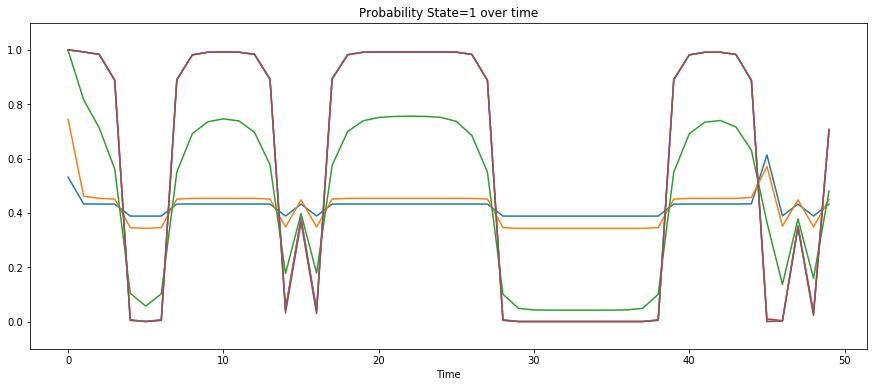

In [22]:
plt.figure(figsize=(15,6))
plt.plot(1-model.state_summary[[0, 4, 6, 8, 9, 10]].T)
plt.ylim(-0.1,1.1)
plt.title('Probability State=1 over time')
plt.xlabel('Time')
plt.draw()

### Plot of True State over Guess Probability of State=1

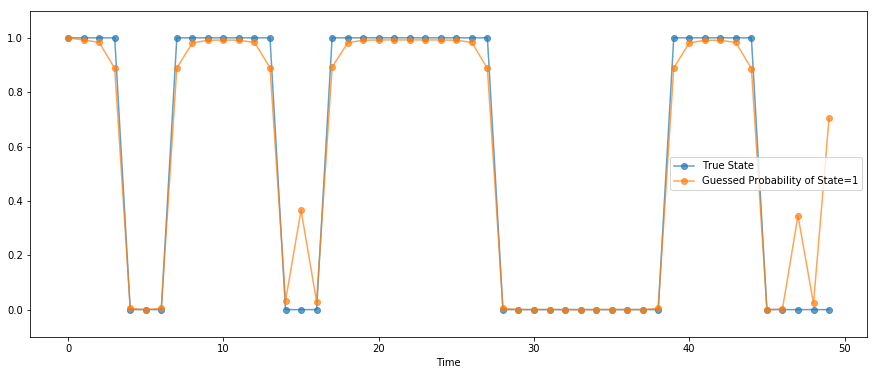

In [23]:
plt.figure(figsize=(15,6))
plt.plot(states.T,'-o',alpha=0.7)
plt.plot(1-model.state_summary[-2].T, '-o',alpha=0.7)
plt.legend(('True State','Guessed Probability of State=1'), loc = 'right')
plt.ylim(-0.1,1.1)
plt.xlabel('Time')
plt.draw()

### Beware of Overfitting

* The algorithm is clearly learning to generate the correct hidden state.
* Baum Welch does, however, overfit quickly.
* It is important to:
    * Train on multiple sequences.
    * Regularize training.
    * Repeat inference with multiple random initial parameters.

In [24]:
pred = (1-model.state_summary[-2]) > 0.5
print("Accuracy: ", np.mean(pred == states))

Accuracy:  0.98


## Visualize the Computation Graph with Tensorboard

Each nodes expends into an exploded view of the computation graph generated by Tensorflow.
Check it out!

**Run Tensorboard on command line :**

> tensorboard --logdir= [graph/file/location](https://github.com/MarvinBertin/HiddenMarkovModel_TensorFlow/tree/master/TensorBoard/Baum-Welch)


![](https://github.com/apester/HiddenMarkovModel_TensorFlow/blob/master/images/BW1.png?raw=1)